In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import healpy as hp

import lsst.daf.butler as dafButler
from lsst.analysis.ap import apdb
from lsst.ap.association import AssociationTask, AssociationConfig
from lsst.dax.apdb import Apdb, ApdbCassandra, ApdbTables
import lsst.geom

from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import ZScaleInterval, ImageNormalize, ManualInterval, AsinhStretch


import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

from typing import TYPE_CHECKING, cast

import astropy.units as u
from astropy.coordinates import SkyCoord

plt.set_loglevel('WARNING')


INFO:numexpr.utils:Note: detected 128 virtual cores but NumExpr set to maximum of 64, check "NUMEXPR_MAX_THREADS" environment variable.
INFO:numexpr.utils:Note: NumExpr detected 128 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


# Imports 

In [2]:
i1 = 7436
i2 = 7565
# why this sometimes takes so long 
# find which ones are variable
df_single_ps1 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i1)+'.parquet')
df_single_ps2 = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps = pd.concat([df_single_ps1, df_single_ps2], ignore_index=True)

df_single_ps1_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i1)+'.parquet')
df_single_ps2_flux = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/pointsource_flux_'+str(i2)+'.parquet')
# Concatenate the dataframes
df_single_ps_flux = pd.concat([df_single_ps1_flux, df_single_ps2_flux], ignore_index=True)

#df_single_sso = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/sso_'+str(i)+'.parquet')
#df_single_gal = pd.read_parquet('/sdf/data/rubin/shared/ops-rehearsals/ops-rehearsal-4/imSim_catalogs/skyCatalogs/galaxy_'+str(i)+'.parquet')
df_single_ps_var = df_single_ps[df_single_ps['is_variable']==True]


ra_min =215.60
ra_max = 216.40
dec_min = -12.90
dec_max = -12.15

# Apply the filter to the dataframe
tru_var_obj = df_single_ps_var[
    (df_single_ps_var['ra'] >= ra_min) & (df_single_ps_var['ra'] <= ra_max) &
    (df_single_ps_var['dec'] >= dec_min) & (df_single_ps_var['dec'] <= dec_max)]

In [3]:
def create_mag_errors(sciFlux, sciFluxErr):
    """Move flux into magnitudes and calculate the error on the magnitude
    
    Parameters
    ----------
    sciFlux : `float`
        Science flux
    sciFluxErr : `float`
        Science flux error

    Returns
    -------
    mag, magerr  : `float`, `float`
        Magnitude and magnitude error
    """
    
    mag = u.nJy.to(u.ABmag, sciFlux)
    upper_mag = u.nJy.to(u.ABmag, sciFlux+sciFluxErr)
    lower_mag = u.nJy.to(u.ABmag, sciFlux-sciFluxErr)
    magErr = -(upper_mag-lower_mag)/2
    
    return mag, magErr

def degrees_to_radians(degrees):
    """
    Convert an angle from degrees to radians.

    Parameters:
    degrees (float): Angle in degrees.

    Returns:
    float: Angle in radians (unitless).
    """
    # Convert the input degrees to radians
    radians = (degrees * u.deg).to(u.rad)
    
    # Return the numerical value (without the unit)
    return radians.value

def radians_to_degrees(radians):
    """
    Convert an angle from radians to degrees.

    Parameters:
    radians (float): Angle in radians.

    Returns:
    float: Angle in degrees (unitless).
    """
    # Convert the input radians to degrees
    degrees = (radians * u.rad).to(u.deg)
    
    # Return the numerical value (without the unit)
    return degrees.value

In [4]:
def plotFlagImages(exp, flagList=['NO_DATA', 'DETECTED', 'DETECTED_NEGATIVE', 'STREAK']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

In [5]:
repo = 'embargo_or4'

instrument = 'LSSTComCamSim'
schema =  f'pp_ppdb_lsstcomcamsim_or4'

butler = dafButler.Butler(repo, instrument=instrument)
registry = butler.registry
# skymap = butler.get("skyMap", collections=collections, skymap="ops_rehersal_prep_2k_v1")
apdbQuery = apdb.ApdbPostgresQuery(instrument=instrument, namespace=schema)

INFO:botocore.credentials:Found credentials in shared credentials file: /sdf/home/n/ncaplar/.lsst/aws-credentials.ini


In [6]:
ra_min = 215.6
ra_max = 216.4
dec_min = -12.9
dec_max = -12.15

ra_min_in_rad = (ra_min*u.deg).to(u.rad).value
ra_max_in_rad = (ra_max*u.deg).to(u.rad).value
dec_min_in_rad = (dec_min*u.deg).to(u.rad).value
dec_max_in_rad = (dec_max*u.deg).to(u.rad).value


In [7]:
with apdbQuery.connection as connection:
    src4_field = pd.read_sql_query(f'''
        SELECT 
            "diaSourceId", 
            "diaObjectId", 
            "ra", 
            "dec", 
            "raErr", 
            "decErr", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "snr", 
            "band", 
            "visit",
            "detector",	
            "x",
            "xErr",
            "y",
            "yErr",
            "time_processed", 
            "time_withdrawn",
            "isDipole",
            "centroid_flag",
            "apFlux_flag",
            "apFlux_flag_apertureTruncated",
            "psfFlux_flag",
            "psfFlux_flag_edge",
            "psfFlux_flag_noGoodPixels",
            "trail_flag_edge",
            "forced_PsfFlux_flag",
            "forced_PsfFlux_flag_edge",
            "forced_PsfFlux_flag_noGoodPixels",
            "shape_flag",
            "shape_flag_no_pixels",
            "shape_flag_not_contained",
            "shape_flag_parent_source",
            "pixelFlags",
            "pixelFlags_bad",
            "pixelFlags_cr",
            "pixelFlags_crCenter",
            "pixelFlags_edge",
            "pixelFlags_interpolated",
            "pixelFlags_interpolatedCenter",
            "pixelFlags_offimage",
            "pixelFlags_saturated",
            "pixelFlags_saturatedCenter",
            "pixelFlags_suspect",
            "pixelFlags_suspectCenter",
            "pixelFlags_streak",
            "pixelFlags_streakCenter",
            "pixelFlags_injected",
            "pixelFlags_injectedCenter",
            "pixelFlags_injected_template",
            "pixelFlags_injected_templateCenter",
            "reliability"
        FROM "{schema}"."DiaSource"
        WHERE "ra" BETWEEN {ra_min} AND {ra_max}
        AND "dec" BETWEEN {dec_min} AND {dec_max}
        LIMIT 3000000;
    ''', connection)

In [8]:
with apdbQuery.connection as connection:
    srcForced4_field = pd.read_sql_query(f'''
        SELECT 
            "diaForcedSourceId", 
            "diaObjectId", 
            "ra", 
            "dec",
            "visit",
            "detector", 
            "midpointMjdTai", 
            "psfFlux", 
            "psfFluxErr", 
            "scienceFlux", 
            "scienceFluxErr", 
            "band"
        FROM "{schema}"."DiaForcedSource"
        WHERE "ra" BETWEEN {ra_min_in_rad} AND {ra_max_in_rad}
        AND "dec" BETWEEN {dec_min_in_rad} AND {dec_max_in_rad}
        LIMIT 3000000;
    ''', connection)
    
srcForced4_field['ra'] = radians_to_degrees(srcForced4_field['ra'].values)
srcForced4_field['dec'] = radians_to_degrees(srcForced4_field['dec'].values)

In [9]:
#latest = False does not work
or4_obj = apdbQuery.load_objects(limit=1e7, latest=True)

# We got all of them, less than 1e7 here
assert len(or4_obj) < 1e7

In [10]:
# lets look at only one field
# objects
obj4_field = or4_obj[(or4_obj['ra'] > ra_min) & (or4_obj['ra'] < ra_max) & (or4_obj['dec'] > dec_min) & (or4_obj['dec'] < dec_max)]
obj4_field

,diaObjectId,validityStart,validityEnd,ra,raErr,dec,decErr,ra_dec_Cov,radecMjdTai,pmRa,...,y_psfFluxPercentile95,y_psfFluxMin,y_psfFluxMax,y_psfFluxStetsonJ,y_psfFluxLinearSlope,y_psfFluxLinearIntercept,y_psfFluxMaxSlope,y_psfFluxErrMean,lastNonForcedSource,nDiaSources
153210,3068394109505896606,2024-06-26 02:48:25+00:00,None,215.889039,NaN,-12.896901,NaN,NaN,60487.114560,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,5
153235,3068394109505896635,2024-06-26 02:52:34+00:00,None,215.948394,2.019397e-05,-12.894802,9.924860e-06,-1.183491e-10,60487.117363,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:51:18+00:00,7
153238,3068394109505896638,2024-06-26 02:54:17+00:00,None,215.922383,5.851012e-07,-12.885339,6.303400e-07,1.301129e-14,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,23
153239,3068394109505896639,2024-06-26 02:58:21+00:00,None,215.966875,8.505353e-06,-12.899532,1.858597e-05,9.602694e-11,60487.118303,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:52:34+00:00,15
153244,3068394109505896644,2024-06-26 02:50:38+00:00,None,215.937075,NaN,-12.884774,NaN,NaN,60487.115963,None,...,None,None,None,None,None,None,None,None,2024-06-26 02:26:12+00:00,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171475,3068394172890218525,2024-06-26 02:55:53+00:00,None,215.635087,NaN,-12.360875,NaN,NaN,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171477,3068394172890218554,2024-06-26 02:55:53+00:00,None,215.690908,3.625022e-05,-12.306796,2.220503e-05,4.035649e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171478,3068394172890218581,2024-06-26 02:55:53+00:00,None,215.665284,2.192825e-05,-12.264642,4.064201e-05,-5.401110e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1
171479,3068394172890218585,2024-06-26 02:55:53+00:00,None,215.677023,2.335178e-05,-12.260069,2.930849e-05,-1.390424e-11,60487.119709,None,...,None,None,None,None,None,None,None,None,1970-01-01 00:00:00+00:00,1


# DM - 46125

In [50]:
repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

In [51]:
list_datasets = list(set(pp_butler.registry.queryDatasets('goodSeeingDiff_assocDiaSrc',  where="instrument='LSSTComCamSim'",  collections=pp_collections)))
# Extract relevant fields: 'detector', 'visit', 'band'
extracted_info = [(item.dataId['detector'], item.dataId['visit'], item.dataId['band']) for item in list_datasets]
extracted_info = pd.DataFrame(extracted_info, columns=['detector', 'visit', 'band']).sort_values(by='visit')
# all the visits in OR4
list_of_visits = (np.unique(extracted_info['visit']))

In [52]:
# visit which exists in the source table but not in goodSeeingDiff_assocDiaSrc table?
np.setxor1d( np.intersect1d(src4_field['visit'].unique(),list_of_visits),src4_field['visit'].unique())

array([7024062500195])

In [53]:
# obj that have nan as raErr or decErr
obj4_field_nan = obj4_field[pd.isna(obj4_field['raErr'])]
# obj that have actual values as raErr or decErr
obj4_field_not_nan = obj4_field[pd.notna(obj4_field['raErr'])]

print(len(obj4_field_not_nan))
print(len(obj4_field_nan))

5876
4066


In [54]:
# select a single object
single_obj = obj4_field_nan[obj4_field_nan['nDiaSources'] > 10].iloc[23]
single_obj = obj4_field_not_nan[obj4_field_not_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394109518479458
validityStart               2024-06-26 02:56:11+00:00
validityEnd                                      None
ra                                         216.165437
raErr                                        0.000008
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:55:46+00:00
nDiaSources                                        19
Name: 154061, Length: 190, dtype: object

In [55]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
print(src_for_single_obj['diaSourceId'].values[0], src_for_single_obj['ra'].values[0], src_for_single_obj['dec'].values[0])

3068394109518479458 216.16532087735004 -12.71539803680108


In [56]:
# select a single source
single_src_id = src_for_single_obj['diaSourceId'].values[0]
print(single_src_id)

3068394109518479458


In [57]:
# selector boolean array
select_single = src_for_single_obj['diaSourceId']==single_src_id
select_single

152       True
1448     False
10758    False
21982    False
25305    False
27819    False
29637    False
33789    False
35253    False
36094    False
38357    False
39371    False
45887    False
47081    False
48372    False
50239    False
51739    False
53329    False
57244    False
Name: diaSourceId, dtype: bool

(7024062500090.0, 7024062500290.0)

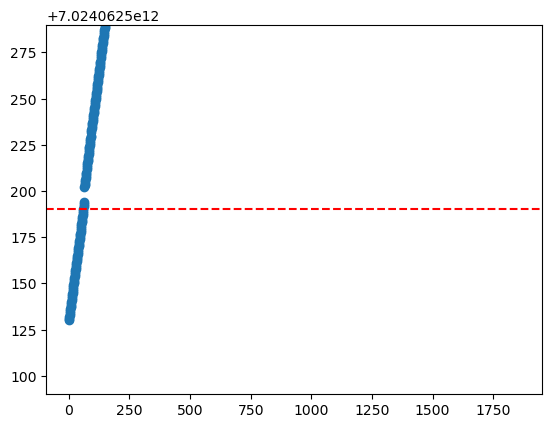

In [58]:
plt.scatter(np.arange(len(list_of_visits)), list_of_visits)
plt.axhline(src_for_single_obj.loc[select_single,'visit'].values[0], color='r', linestyle='--')  
plt.ylim(src_for_single_obj.loc[select_single,'visit'].values[0] - 100 , src_for_single_obj.loc[select_single,'visit'].values[0] + 100)

In [59]:
# position of the source
center = lsst.geom.SpherePoint(src_for_single_obj.loc[select_single,'ra'], src_for_single_obj.loc[select_single,'dec'] , lsst.geom.degrees)
center

SpherePoint(216.16532087735004*degrees, -12.71539803680108*degrees)

In [60]:
extent = lsst.geom.Extent2I(200, 200)
data1= {'detector': src_for_single_obj.loc[select_single,'detector'].values[0], 'visit': src_for_single_obj.loc[select_single,'visit'].values[0]}

src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)

one_pp_science = pp_butler.get('initial_pvi', dataId=data1)
one_pp_template = pp_butler.get('goodSeeingDiff_templateExp', dataId=data1)
one_pp_diffim = pp_butler.get('goodSeeingDiff_differenceExp', dataId=data1)

science_cutout = one_pp_science.getCutout(center, extent)
template_cutout = one_pp_template.getCutout(center, extent)
difference_cutout = one_pp_diffim.getCutout(center, extent)

In [61]:
# check that source is there via butler
src_for_single_obj_via_butler = src_via_butler[src_via_butler['diaObjectId'] == src_for_single_obj['diaObjectId'].values[0]]
src_for_single_obj_via_butler

,,,diaSourceId,visit,detector,diaObjectId,ssObjectId,parentDiaSourceId,ssObjectReassocTime,midpointMjdTai,ra,raErr,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,programId
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,,,,,,
3068394109518479458,i,3068394109518479458,3068394109518479458,7024062500190,3,3068394109518479458,0,0,NaT,60487.08931,216.165321,0.000008,...,False,False,False,False,False,False,False,False,False,0


In [62]:
src_for_single_obj[src_for_single_obj['visit'] == src_for_single_obj_via_butler['visit'].values[0]]

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability
152,3068394109518479458,3068394109518479458,216.165321,-12.715398,0.000008,0.00001,60487.08931,4106.269531,348.134827,98635.84375,...,False,False,False,False,False,False,False,False,False,None


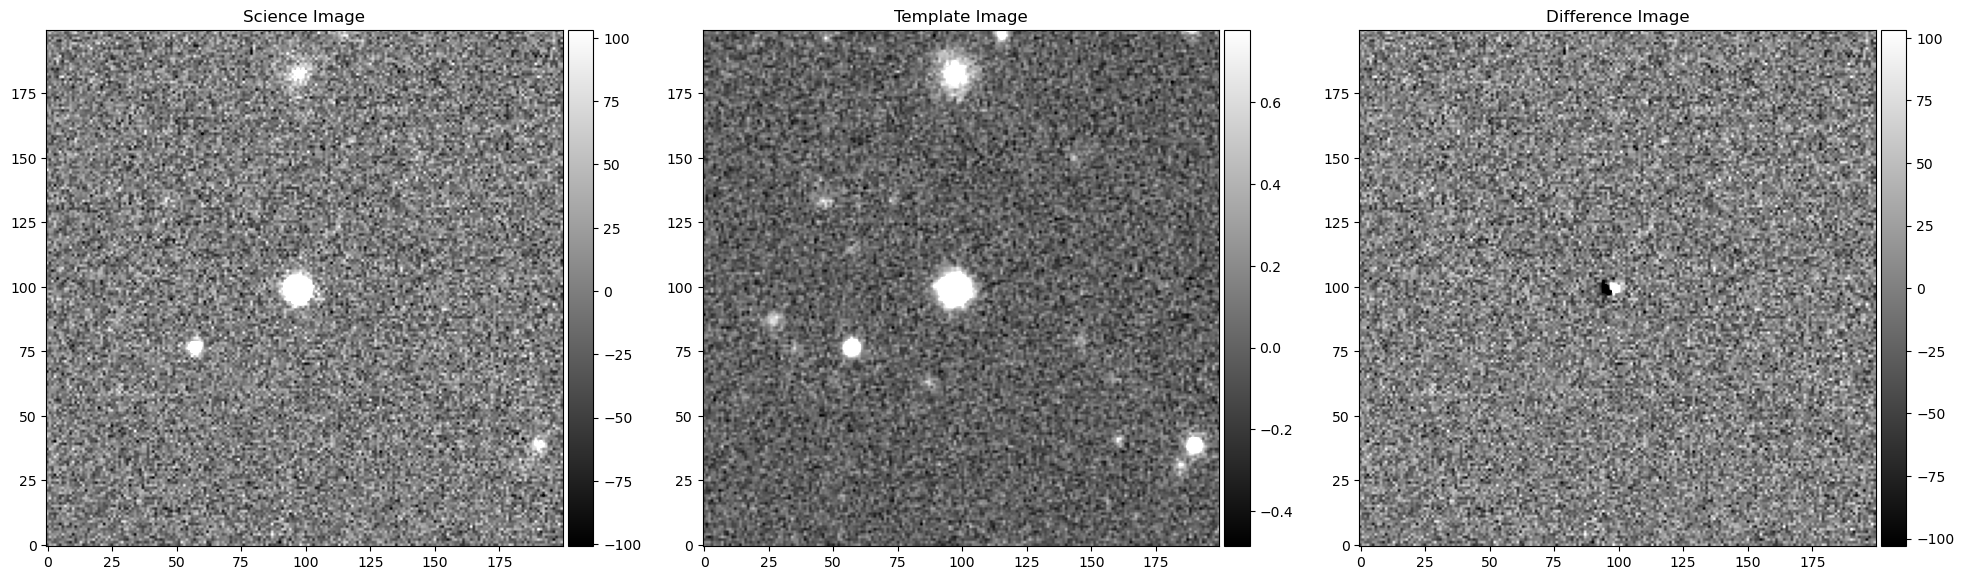

In [63]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.image.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.image.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.image.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')

# Show the plot
plt.show()


Text(0.5, 1.0, 'Difference Image')

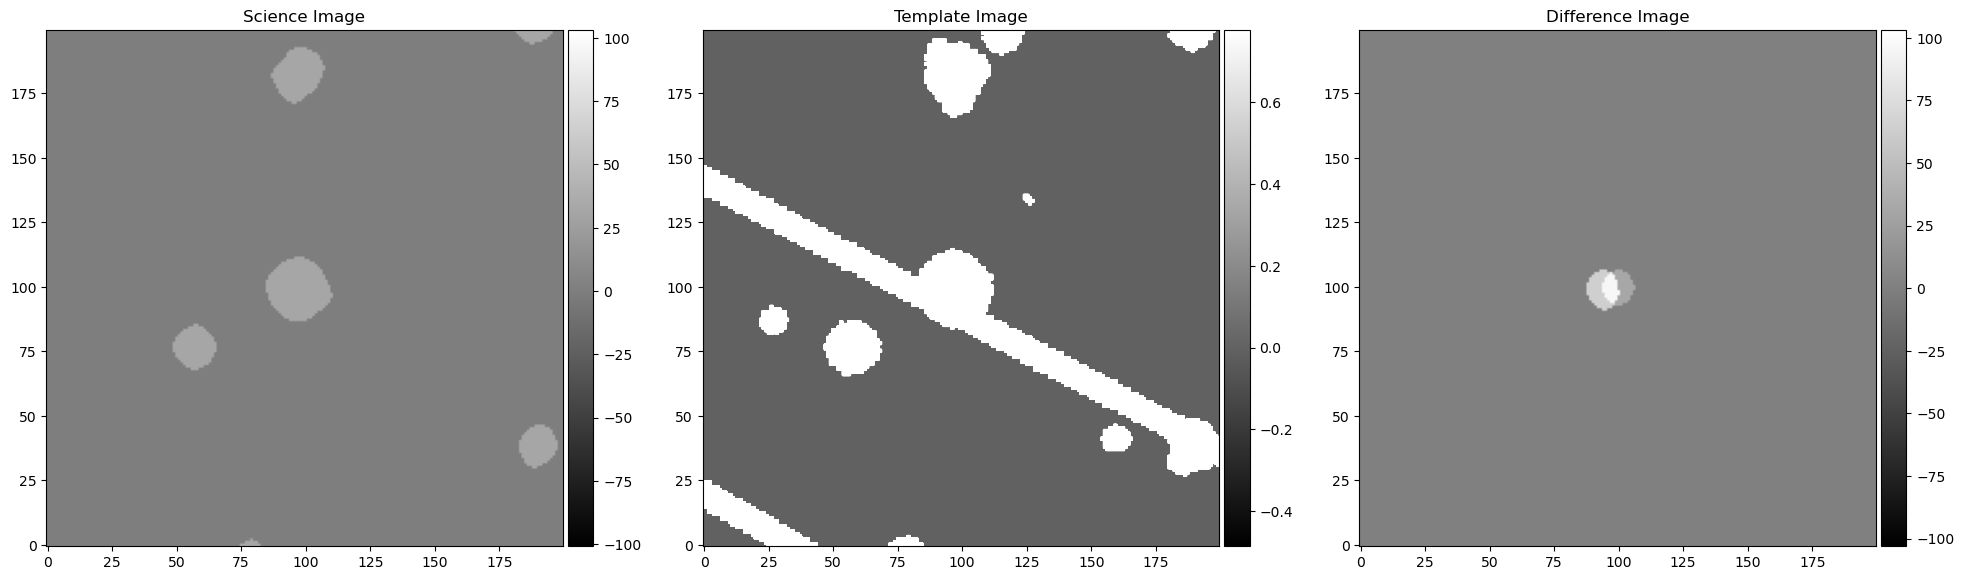

In [64]:
# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,8))


# Normalize the science and template images using ZScaleInterval
norm_science = ImageNormalize(science_cutout.image.array, interval=ZScaleInterval())
norm_template = ImageNormalize(template_cutout.image.array, interval=ZScaleInterval())

# Normalize the diffim image symmetrically around 0 using ManualInterval and SqrtStretch
max_abs_val = norm_science.vmax  # Find max absolute value
norm_diffim = ImageNormalize(vmin=-max_abs_val, vmax=max_abs_val)


# Display the images and store the imshow object for adding colorbars
img1 = ax1.imshow(science_cutout.mask.array, origin='lower', norm=norm_science, cmap='gray')
img2 = ax2.imshow(template_cutout.mask.array, origin='lower', norm=norm_template, cmap='gray')
img3 = ax3.imshow(difference_cutout.mask.array, origin='lower', norm=norm_diffim, cmap='gray')


# Add colorbars for each image
# Create colorbars with appropriate sizes next to each subplot
for ax, img in zip([ax1, ax2, ax3], [img1, img2, img3]):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(img, cax=cax, orientation='vertical')

# Set individual titles above each image
ax1.set_title('Science Image')
ax2.set_title('Template Image')
ax3.set_title('Difference Image')


In [65]:
template_cutout.mask.getMaskPlaneDict().items()

dict_items([('BAD', 0), ('CLIPPED', 9), ('CR', 3), ('DETECTED', 5), ('DETECTED_NEGATIVE', 6), ('EDGE', 4), ('INEXACT_PSF', 10), ('INJECTED', 11), ('INJECTED_TEMPLATE', 12), ('INTRP', 2), ('NOT_DEBLENDED', 13), ('NO_DATA', 8), ('REJECTED', 14), ('SAT', 1), ('SAT_TEMPLATE', 15), ('SENSOR_EDGE', 16), ('STREAK', 17), ('SUSPECT', 7), ('UNMASKEDNAN', 18)])

In [66]:
print(np.unique(template_cutout.mask.array))
print(np.unique(difference_cutout.mask.array))
print(np.unique(science_cutout.mask.array))

[    0    12    32 66560 66592]
[ 0 32 64 96]
[ 0 32]


In [67]:
def plotFlagImages(exp, flagList=['DETECTED_NEGATIVE', 'DETECTED', 'SENSOR_EDGE', 'INEXACT_PSF']):
    fig = plt.figure(figsize=(24,8))
    #plt.suptitle(dataId)
    fig.add_subplot(1, len(flagList)+1, 1)
    norm = ImageNormalize(exp.image.array, interval=ZScaleInterval(), stretch=SqrtStretch())
    im = plt.imshow(exp.image.array, origin='lower', norm=norm, cmap='gray')
    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])
    plt.title('diffim')
    i = 1
    for (name, bit) in exp.mask.getMaskPlaneDict().items():
        if name in flagList:
            
            fig.add_subplot(1, len(flagList)+1, i + 1)
            im = plt.imshow(np.where(exp.mask.array & 2**bit, 1, 0),
                       origin='lower', cmap='GnBu', interpolation='nearest')
            plt.title(name)
            plt.gca().axes.xaxis.set_ticklabels([])
            plt.gca().axes.yaxis.set_ticklabels([])
            i = i + 1
            del im

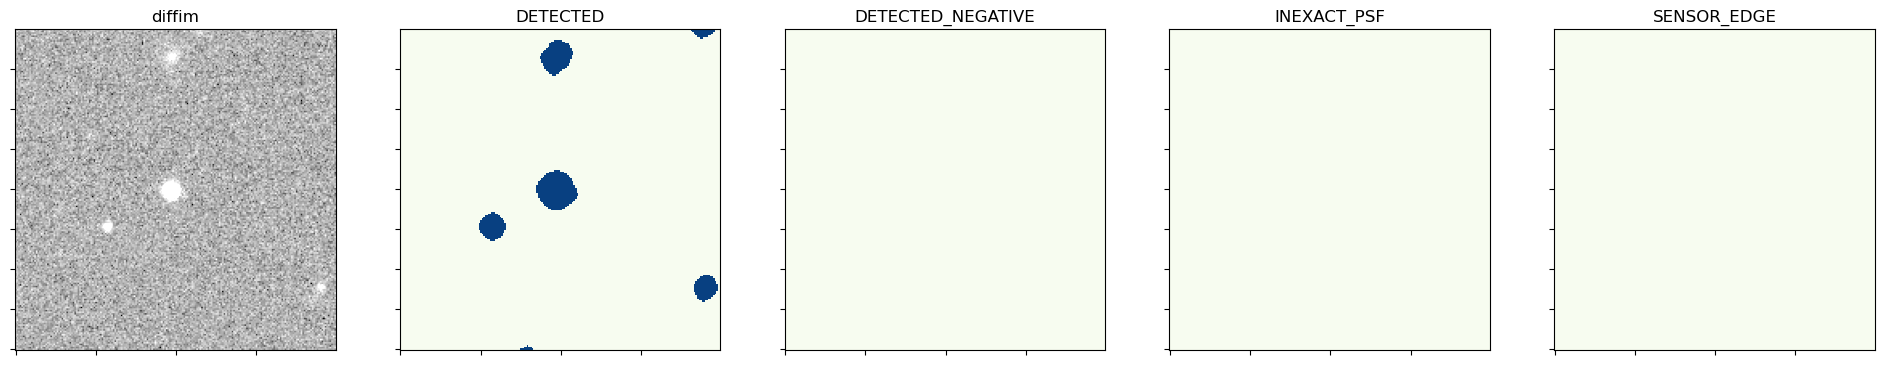

In [68]:
plotFlagImages(science_cutout)

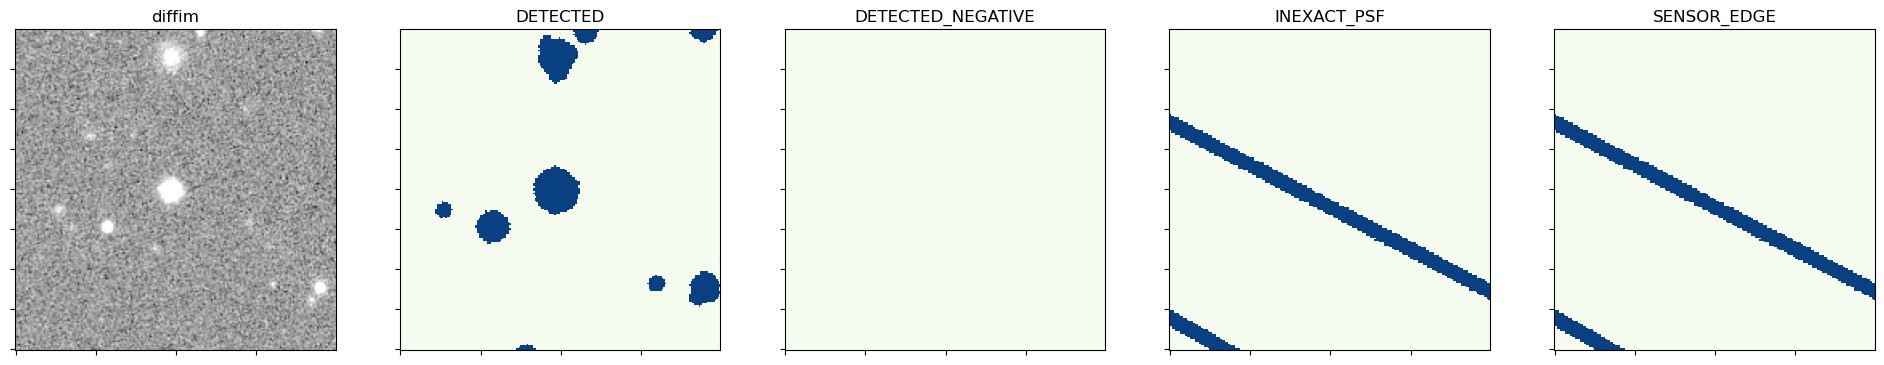

In [69]:
plotFlagImages(template_cutout)

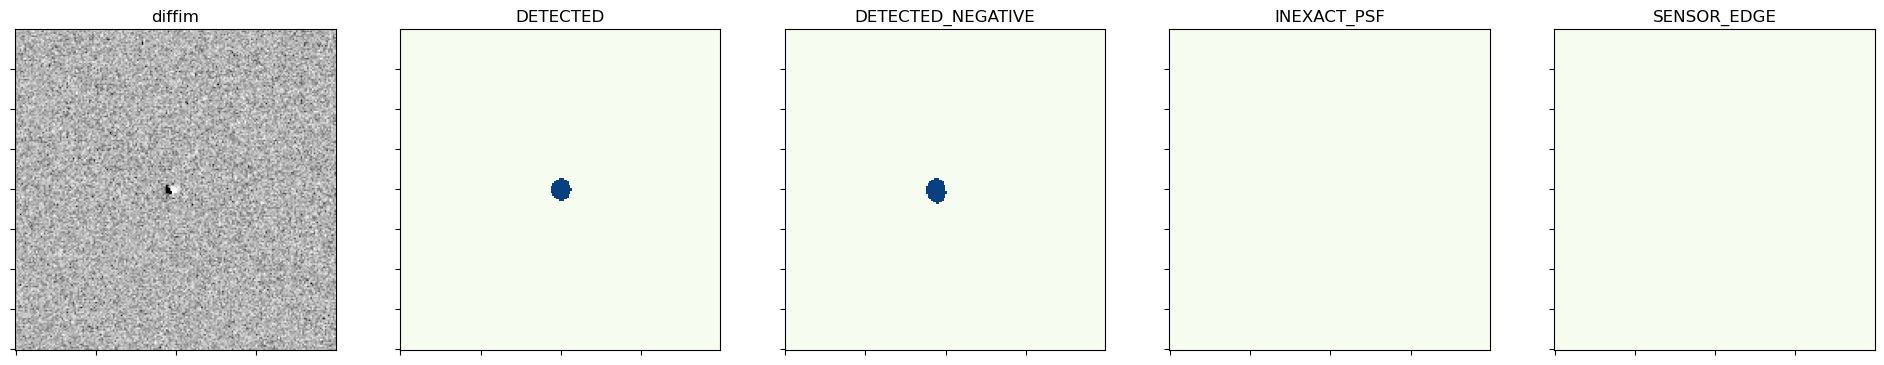

In [70]:
plotFlagImages(difference_cutout)

In [71]:
single_obj = obj4_field_nan[obj4_field_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394111678546018
validityStart               2024-06-26 02:55:53+00:00
validityEnd                                      None
ra                                         216.280468
raErr                                             NaN
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:53:01+00:00
nDiaSources                                        28
Name: 155859, Length: 190, dtype: object

In [72]:
single_obj = obj4_field_not_nan[obj4_field_not_nan['nDiaSources'] > 10].iloc[230]
single_obj

diaObjectId                       3068394109518479458
validityStart               2024-06-26 02:56:11+00:00
validityEnd                                      None
ra                                         216.165437
raErr                                        0.000008
                                      ...            
y_psfFluxLinearIntercept                         None
y_psfFluxMaxSlope                                None
y_psfFluxErrMean                                 None
lastNonForcedSource         2024-06-26 02:55:46+00:00
nDiaSources                                        19
Name: 154061, Length: 190, dtype: object

In [73]:
# select all sources for this object
src_for_single_obj = src4_field[(src4_field['diaObjectId']==single_obj['diaObjectId']) ]
src_for_single_obj[['centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
152,False,False,False,False,True
1448,False,False,False,False,False
10758,True,True,True,True,True
21982,True,True,True,True,True
25305,True,True,True,True,True
27819,False,False,False,False,False
29637,False,False,False,False,True
33789,False,False,False,False,False
35253,False,False,False,False,True
36094,False,False,False,False,False


In [74]:
src_for_single_obj.loc[45887]

diaSourceId                                 3068394170709180481
diaObjectId                                 3068394109518479458
ra                                                   216.165468
dec                                                  -12.715666
raErr                                                       NaN
decErr                                                      NaN
midpointMjdTai                                      60487.11877
psfFlux                                            -1608.145874
psfFluxErr                                           303.842804
scienceFlux                                        61105.542969
scienceFluxErr                                       296.876678
snr                                                    5.301852
band                                                          r
visit                                             7024062500247
detector                                                      0
x                                       

In [75]:
src_for_single_obj[['diaSourceId', 'raErr', 'decErr', 'xErr', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,diaSourceId,raErr,decErr,xErr,yErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
152,3068394109518479458,0.000008,0.000010,NaN,NaN,4106.269531,i,False,False,False,False,True
1448,3068394111653380230,0.000010,0.000012,0.175130,0.211453,4028.226074,i,False,False,False,False,False
10758,3068394133144993855,NaN,NaN,NaN,NaN,-1692.929199,g,True,True,True,True,True
21982,3068394146017312928,NaN,NaN,NaN,NaN,-1451.361938,g,True,True,True,True,True
25305,3068394150308085797,NaN,NaN,NaN,NaN,-2636.998779,g,True,True,True,True,True
27819,3068394152459763779,0.000022,0.000029,0.381295,0.539300,1860.563477,r,False,False,False,False,False
29637,3068394155676794899,0.000016,0.000022,NaN,NaN,2031.590576,r,False,False,False,False,True
33789,3068394159971762331,0.000010,0.000009,NaN,NaN,4334.764160,r,False,False,False,False,False
35253,3068394161058086982,0.000017,0.000015,NaN,NaN,1988.346924,r,False,False,False,False,True
36094,3068394162119245909,0.000015,0.000015,0.278583,0.272957,2384.051270,r,False,False,False,False,False


In [ ]:
# If xErr and yErr are NaN, raErr and decErr are not NaN if isDipole is True
# If xErr and yErr are NaN, raErr and decErr are NaN if isDipole is False

In [95]:
# find this source in the butler, but as a candidate and associate it with the source

#example with a source that has Nan for xErr and yErr, but has errors for raErr and decErr

data1= {'detector': 3, 'visit': 7024062500190}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394109518479458]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394109518479458]

In [118]:
single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,,,diaSourceId,ra,raErr,dec,decErr,x,xErr,y,yErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,
3068394109518479458,i,3068394109518479458,3068394109518479458,216.165321,0.000008,-12.715398,0.00001,431.811554,NaN,1537.749512,NaN,4106.269531,i,False,False,False,False,True


In [125]:
catalog = single_butler_cand_src
columns = catalog.schema.getNames()  # Get all column names
data = {col: catalog[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
df = pd.DataFrame(data)

df[['id', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

,id,srcMatchId,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_xErr,base_SdssCentroid_y,base_SdssCentroid_yErr,base_PsfFlux_instFlux
0,3068394109518479458,0,3.772797,1.309876e-07,-0.221926,1.661769e-07,434.075123,0.133803,1538.242949,0.174691,4106.269749


In [136]:
# example where they are both Nan

src4_field[src4_field['diaSourceId'] == 3068394133144993855][['visit', 'detector']]



,visit,detector
10758,7024062500212,4


In [137]:
data1= {'detector': 4, 'visit': 7024062500212}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394133144993855]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394133144993855]

In [138]:
single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,,,diaSourceId,ra,raErr,dec,decErr,x,xErr,y,yErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,
3068394109518479458,g,3068394133144993855,3068394133144993855,216.165366,NaN,-12.715597,NaN,888.0,NaN,1046.0,NaN,-1692.929199,g,True,True,True,True,True


In [140]:

columns = single_butler_cand_src.schema.getNames()  # Get all column names
data = {col: single_butler_cand_src[col].tolist() for col in columns}  # Extract each column's data

# Create a pandas DataFrame
single_butler_cand_src_df = pd.DataFrame(data)

single_butler_cand_src_df[['id', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

,id,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_xErr,base_SdssCentroid_y,base_SdssCentroid_yErr,base_PsfFlux_instFlux
0,3068394133144993855,3.772797,NaN,-0.221929,NaN,888.0,NaN,1046.0,NaN,-1692.929254


In [132]:
src4_field

,diaSourceId,diaObjectId,ra,dec,raErr,decErr,midpointMjdTai,psfFlux,psfFluxErr,scienceFlux,...,pixelFlags_saturatedCenter,pixelFlags_suspect,pixelFlags_suspectCenter,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,reliability
0,3068394109514285084,3068394109514285084,215.630838,-12.872106,NaN,NaN,60487.08931,-1946.655640,265.989258,38199.613281,...,False,False,False,False,False,False,False,False,False,None
1,3068394109514285091,3068394109514285091,215.605865,-12.862209,0.000006,0.000005,60487.08931,9831.191406,490.275330,228865.218750,...,False,False,False,False,False,False,False,False,False,None
2,3068394109514285097,3068394109514285097,215.600511,-12.857998,0.000005,0.000004,60487.08931,11874.484375,574.258484,266401.906250,...,False,False,False,False,False,False,False,False,False,None
3,3068394109514285112,3068394109514285112,215.612834,-12.852351,0.000027,0.000021,60487.08931,1254.862061,220.586670,1145.690308,...,False,False,False,False,False,False,False,False,False,None
4,3068394109514285133,3068394109514285133,215.603055,-12.837839,0.000016,0.000022,60487.08931,1797.926636,223.478989,1748.432129,...,False,False,False,False,False,False,False,False,False,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58246,3068394109510091044,3068394109510091044,215.765043,-12.697895,0.000003,0.000003,60487.08931,26648.339844,838.973572,656642.375000,...,False,False,False,False,False,False,False,False,False,None
58247,3068394109510091045,3068394109510091045,215.770285,-12.699382,0.000005,0.000004,60487.08931,10978.866211,546.268433,267710.343750,...,False,False,False,False,False,False,False,False,False,None
58248,3068394109510091046,3068394109510091046,215.859529,-12.726200,0.000007,0.000008,60487.08931,3998.014160,348.533844,88400.546875,...,False,False,False,False,False,False,False,False,False,None
58249,3068394109510091047,3068394109510091047,215.866092,-12.728171,0.000012,0.000013,60487.08931,2391.240234,298.150330,53120.347656,...,False,False,False,False,False,False,False,False,False,None


In [143]:
# creating a minimal example
import lsst.daf.butler as dafButler

repo = 'embargo_or4'
instrument = 'LSSTComCamSim'
pp_collections = ['LSSTComCamSim/prompt/output-2024-06-25', 'LSSTComCamSim/prompt/output-2024-06-26', 'LSSTComCamSim/prompt/output-2024-06-27']
pp_butler = dafButler.Butler(repo, collections=pp_collections, instrument=instrument)

data1= {'detector': 3, 'visit': 7024062500190}
src_via_butler = pp_butler.get('goodSeeingDiff_assocDiaSrc', dataId=data1)
src_cand_via_butler = pp_butler.get('goodSeeingDiff_candidateDiaSrc', dataId=data1)

single_butler_src = src_via_butler[src_via_butler['diaSourceId'] == 3068394109518479458]
single_butler_cand_src = src_cand_via_butler[src_cand_via_butler['id'] == 3068394109518479458]

single_butler_src[['diaSourceId', 'ra', 'raErr', 'dec', 'decErr', 'x', 'xErr', 'y', 'yErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]


,,,diaSourceId,ra,raErr,dec,decErr,x,xErr,y,yErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
diaObjectId,band,diaSourceId,,,,,,,,,,,,,,,,
3068394109518479458,i,3068394109518479458,3068394109518479458,216.165321,0.000008,-12.715398,0.00001,431.811554,NaN,1537.749512,NaN,4106.269531,i,False,False,False,False,True


In [142]:
# new cell
columns = single_butler_cand_src.schema.getNames()  # Get all column names
data = {col: single_butler_cand_src[col].tolist() for col in columns}  # Extract each column's data
single_butler_cand_src_df = pd.DataFrame(data)
single_butler_cand_src_df[['id', 'coord_ra', 'coord_raErr', 'coord_dec', 'coord_decErr', 'base_SdssCentroid_x', 'base_SdssCentroid_xErr', 'base_SdssCentroid_y', 'base_SdssCentroid_yErr', 'base_PsfFlux_instFlux']]

,id,coord_ra,coord_raErr,coord_dec,coord_decErr,base_SdssCentroid_x,base_SdssCentroid_xErr,base_SdssCentroid_y,base_SdssCentroid_yErr,base_PsfFlux_instFlux
0,3068394109518479458,3.772797,1.309876e-07,-0.221926,1.661769e-07,434.075123,0.133803,1538.242949,0.174691,4106.269749


In [144]:
columns

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_InvalidPsf_flag',
 'base_LocalPhotoCalib',
 'base_LocalPhotoCalibErr',
 'base_LocalPhotoCalib_flag',
 'base_LocalWcs_CDMatrix_1_1',
 'base_LocalWcs_CDMatrix_1_2',
 'base_LocalWcs_CDMatrix_2_1',
 'base_LocalWcs_CDMatrix_2_2',
 'base_LocalWcs_flag',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_badCenter',
 'base_PixelFlags_flag_badCenterAll',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_crCenterAll',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_edgeCenter',
 'base_PixelFlags_flag_edgeCenterAll',
 'base_PixelFlags_flag_injected',
 'base_PixelFlags_flag_injectedCenter',
 'base_PixelFlags_flag_injectedCenterAll',
 'base_PixelFlags_flag_injected_template',
 'base_PixelFlags_flag_injected_templateCenter',
 'base_PixelFlag

In [112]:
columns

{'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_instFlux',
 'base_CircularApertureFlux_12_0_instFluxErr',
 'base_InvalidPsf_flag',
 'base_LocalPhotoCalib',
 'base_LocalPhotoCalibErr',
 'base_LocalPhotoCalib_flag',
 'base_LocalWcs_CDMatrix_1_1',
 'base_LocalWcs_CDMatrix_1_2',
 'base_LocalWcs_CDMatrix_2_1',
 'base_LocalWcs_CDMatrix_2_2',
 'base_LocalWcs_flag',
 'base_PixelFlags_flag',
 'base_PixelFlags_flag_bad',
 'base_PixelFlags_flag_badCenter',
 'base_PixelFlags_flag_badCenterAll',
 'base_PixelFlags_flag_cr',
 'base_PixelFlags_flag_crCenter',
 'base_PixelFlags_flag_crCenterAll',
 'base_PixelFlags_flag_edge',
 'base_PixelFlags_flag_edgeCenter',
 'base_PixelFlags_flag_edgeCenterAll',
 'base_PixelFlags_flag_injected',
 'base_PixelFlags_flag_injectedCenter',
 'base_PixelFlags_flag_injectedCenterAll',
 'base_PixelFlags_flag_injected_template',
 'base_PixelFlags_flag_injected_templateCenter',
 'base_PixelFlag

In [101]:
single_butler_cand_src.

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... srcMatchId sky_source
                           rad         ...                      
------------------- ------------------ ... ---------- ----------
3068394109518479458 3.7727965779397956 ...          0      False

In [93]:
src_cand_via_butler

<class 'lsst.afw.table.SourceCatalog'>
         id              coord_ra      ... srcMatchId sky_source
                           rad         ...                      
------------------- ------------------ ... ---------- ----------
3068394109518479361  3.770136114820828 ...          0      False
3068394109518479362 3.7702406764573064 ...          0      False
3068394109518479363 3.7702191135069847 ...          0      False
3068394109518479364   3.77100648008478 ...          0      False
3068394109518479365 3.7726778283477884 ...          0      False
3068394109518479366 3.7700050867928567 ...          0      False
3068394109518479367 3.7702560169191672 ...          0      False
3068394109518479368  3.771891431711748 ...          0      False
3068394109518479369   3.77145643633392 ...          0      False
                ...                ... ...        ...        ...
3068394109518479612 3.7726234350409373 ...          0      False
3068394109518479613 3.7735290304142652 ...         

## Statistical analysis

In [76]:
list(obj4_field_nan.columns)

['diaObjectId',
 'validityStart',
 'validityEnd',
 'ra',
 'raErr',
 'dec',
 'decErr',
 'ra_dec_Cov',
 'radecMjdTai',
 'pmRa',
 'pmRaErr',
 'pmDec',
 'pmDecErr',
 'parallax',
 'parallaxErr',
 'pmRa_pmDec_Cov',
 'pmRa_parallax_Cov',
 'pmDec_parallax_Cov',
 'pmParallaxLnL',
 'pmParallaxChi2',
 'pmParallaxNdata',
 'u_psfFluxMean',
 'u_psfFluxMeanErr',
 'u_psfFluxSigma',
 'u_psfFluxChi2',
 'u_psfFluxNdata',
 'u_fpFluxMean',
 'u_fpFluxMeanErr',
 'u_fpFluxSigma',
 'g_psfFluxMean',
 'g_psfFluxMeanErr',
 'g_psfFluxSigma',
 'g_psfFluxChi2',
 'g_psfFluxNdata',
 'g_fpFluxMean',
 'g_fpFluxMeanErr',
 'g_fpFluxSigma',
 'r_psfFluxMean',
 'r_psfFluxMeanErr',
 'r_psfFluxSigma',
 'r_psfFluxChi2',
 'r_psfFluxNdata',
 'r_fpFluxMean',
 'r_fpFluxMeanErr',
 'r_fpFluxSigma',
 'i_psfFluxMean',
 'i_psfFluxMeanErr',
 'i_psfFluxSigma',
 'i_psfFluxChi2',
 'i_psfFluxNdata',
 'i_fpFluxMean',
 'i_fpFluxMeanErr',
 'i_fpFluxSigma',
 'z_psfFluxMean',
 'z_psfFluxMeanErr',
 'z_psfFluxSigma',
 'z_psfFluxChi2',
 'z_psfFluxNd

(-10000.0, 10000.0)

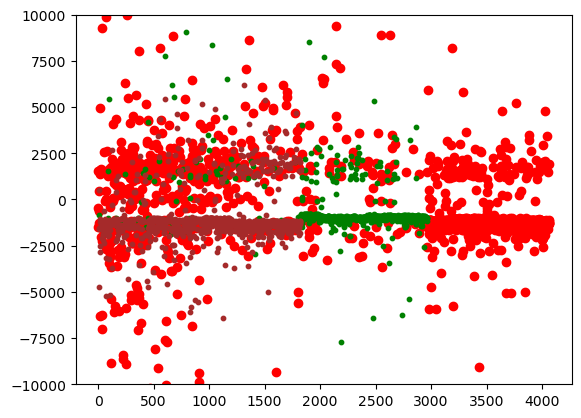

In [77]:
obj4_field_nan_min_max = obj4_field_nan[['diaObjectId','g_psfFluxMean', 'g_psfFluxMin', 'g_psfFluxMax', 'r_psfFluxMean', 'r_psfFluxMin', 'r_psfFluxMax', 'i_psfFluxMean', 'i_psfFluxMin', 'i_psfFluxMax']]

plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['r_psfFluxMean'].values, color='red')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['g_psfFluxMean'].values, s=10, color='g')
plt.scatter(np.arange(len(obj4_field_nan_min_max)), obj4_field_nan_min_max['i_psfFluxMean'].values, s=10, color='brown')
plt.ylim(-10000, 10000)

In [78]:
obj4_field_nan_min_max[obj4_field_nan_min_max['r_psfFluxMean']>1000]

,diaObjectId,g_psfFluxMean,g_psfFluxMin,g_psfFluxMax,r_psfFluxMean,r_psfFluxMin,r_psfFluxMax,i_psfFluxMean,i_psfFluxMin,i_psfFluxMax
153210,3068394109505896606,NaN,NaN,NaN,1518.954346,1518.954346,1518.954346,NaN,NaN,NaN
153293,3068394109505896700,NaN,NaN,NaN,1437.075562,1437.075562,1437.075562,NaN,NaN,NaN
153298,3068394109505896705,NaN,NaN,NaN,4969.968262,3656.614990,9012.880859,NaN,NaN,NaN
153313,3068394109505896723,NaN,NaN,NaN,1355.668823,1355.668823,1355.668823,NaN,NaN,NaN
153315,3068394109505896725,NaN,NaN,NaN,1581.683838,1581.683838,1581.683838,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
171406,3068394172869247095,NaN,NaN,NaN,1629.364624,1629.364624,1629.364624,NaN,NaN,NaN
171432,3068394172881829904,NaN,NaN,NaN,1935.905151,1935.905029,1935.905029,NaN,NaN,NaN
171439,3068394172881829934,NaN,NaN,NaN,3431.348633,3431.348877,3431.348877,NaN,NaN,NaN
171444,3068394172881829955,NaN,NaN,NaN,1486.537964,1486.538086,1486.538086,NaN,NaN,NaN


In [79]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']]

,diaSourceId,raErr,decErr,psfFlux,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
0,3068394109514285084,NaN,NaN,-1946.655640,i,True,True,True,True,True
1,3068394109514285091,0.000006,0.000005,9831.191406,i,False,False,False,False,True
2,3068394109514285097,0.000005,0.000004,11874.484375,i,False,False,False,False,True
3,3068394109514285112,0.000027,0.000021,1254.862061,i,False,False,False,False,False
4,3068394109514285133,0.000016,0.000022,1797.926636,i,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...
58246,3068394109510091044,0.000003,0.000003,26648.339844,i,False,False,False,False,False
58247,3068394109510091045,0.000005,0.000004,10978.866211,i,False,False,False,False,False
58248,3068394109510091046,0.000007,0.000008,3998.014160,i,False,False,False,False,True
58249,3068394109510091047,0.000012,0.000013,2391.240234,i,False,False,False,False,True


In [80]:
print(len(src4_field))

print(len(src4_field[ (src4_field['psfFlux']<0)]['raErr']))
print(len(src4_field[(src4_field['shape_flag']==True)]))
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']<0)]['raErr']
print(len(src_shape_negative))
src_shape_negative[~np.isnan(src_shape_negative)].index
print(np.sum(np.isnan(src4_field['raErr'])))

58251
15782
29300
15778
16401


In [81]:
np.sum(np.isnan(src4_field['raErr']))

16401

In [82]:
src4_field[['diaSourceId', 'raErr', 'decErr', 'psfFlux', 'psfFluxErr', 'band', 'centroid_flag', 'apFlux_flag', 'psfFlux_flag', 'forced_PsfFlux_flag', 'shape_flag']].loc[src_shape_negative[~np.isnan(src_shape_negative)].index]

,diaSourceId,raErr,decErr,psfFlux,psfFluxErr,band,centroid_flag,apFlux_flag,psfFlux_flag,forced_PsfFlux_flag,shape_flag
1311,3068394109539451098,0.000366,0.000131,-1482.257935,233.992737,i,True,True,True,True,True
2152,3068394111670157475,0.000027,0.000037,-92.264366,216.773254,i,False,False,False,False,True
2311,3068394111674351700,0.000035,0.000073,-580.065918,232.914749,i,False,False,False,False,True
3885,3068394112743899273,0.000238,0.000072,-640.667603,224.214325,i,True,True,True,True,True
3903,3068394112743899298,0.000322,0.000090,-2063.958252,581.654968,i,False,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...
53355,3068394129906991262,0.000851,0.001028,-291.092712,814.717468,i,False,False,False,False,True
54371,3068394123485511681,0.000076,0.000012,-1725.450439,374.449738,i,True,True,True,True,True
55145,3068394124542476388,0.000091,0.000020,-37.486374,237.978043,i,False,False,False,False,True
55606,3068394124571836466,0.000013,0.000029,-513.365417,264.827393,i,False,False,False,False,True


In [83]:
src_shape_negative = src4_field[(src4_field['shape_flag']==True) & (src4_field['psfFlux']>0)]['raErr']
src_shape_negative[~np.isnan(src_shape_negative)]

1        0.000006
2        0.000005
6        0.000022
21       0.000013
22       0.000004
           ...   
58237    0.000011
58241    0.000010
58243    0.000004
58248    0.000007
58249    0.000012
Name: raErr, Length: 12835, dtype: float64